# 🫀 Detecção de Picos PPG com Performer (Transformer)

Este notebook usa os dados **locais do MIMIC-II** (BIDMC) e treina um modelo
**Performer** (Transformer com atenção linear O(n)) para detectar picos sistólicos.

## Pipeline:
1. Carregar os 53 registros locais (BIDMC)
2. Detectar picos R no ECG (Lead II) → criar labels para PPG
3. Treinar Performer para prever posição do pico
4. Validação Leave-One-Subject-Out (LOSO)
5. Testar nos seus dados ESP32

## 📦 Instalação de Dependências

Execute apenas uma vez.

In [1]:
!pip install numpy scipy scikit-learn matplotlib torch einops performer-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 10.4 MB/s  0:00:03 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 10.9 MB/s  0:00:00 11.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 10.1 MB/s  0:01:22 eta 0:00:010:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 11.0 MB/s  0:00:01 11.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 10.5 MB/s  0:00:53 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.9 MB/s  0:00:0011.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 11.1 MB/s  0:00:07 eta 0:00:010:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 10.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 10.3 MB/s  0:01:03 eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 10.6 MB/s  0:00:18 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 M

## 1. Importações e Configurações

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, resample
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 100

# Parâmetros
FS = 125                    # Taxa de amostragem BIDMC (Hz)
WINDOW_SEC = 4              # Janela de 4 segundos
WINDOW_SIZE = WINDOW_SEC * FS  # 500 amostras
STRIDE = WINDOW_SIZE // 2   # 50% overlap

# Caminhos
MIMIC_DIR = '/home/douglas/Documentos/Projects/PPG/pulse-analytics/analytics/datasets/ MIMIC II'
ESP32_DIR = '/home/douglas/Documentos/Projects/PPG/pulse-analytics/analytics/datasets'

print(f"✅ Configurações:")
print(f"   - Janela: {WINDOW_SEC}s = {WINDOW_SIZE} samples @ {FS}Hz")
print(f"   - Dataset: {MIMIC_DIR}")

✅ Configurações:
   - Janela: 4s = 500 samples @ 125Hz
   - Dataset: /home/douglas/Documentos/Projects/PPG/pulse-analytics/analytics/datasets/ MIMIC II


## 2. Carregando Dados Locais BIDMC (MIMIC-II)

In [3]:
def load_bidmc_record(filepath):
    """
    Carrega um registro BIDMC do CSV local.
    
    Returns:
        ppg: Sinal PPG (PLETH)
        ecg: Sinal ECG (Lead II)
        fs: Taxa de amostragem (125Hz)
    """
def load_bidmc_record(filepath):
    df = pd.read_csv(filepath)
    
    
    # CORREÇÃO: Remover espaços dos nomes das colunas
    df.columns = df.columns.str.strip()

    # Extrair sinais
    ppg = df['PLETH'].values
    ecg = df['II'].values
    
    # Remover NaN
    ppg = np.nan_to_num(ppg, nan=np.nanmean(ppg))
    ecg = np.nan_to_num(ecg, nan=np.nanmean(ecg))
    
    return ppg, ecg, FS


def load_all_subjects(mimic_dir):
    """
    Carrega todos os 53 sujeitos do BIDMC.
    
    Returns:
        subjects: Lista de dicts com 'id', 'ppg', 'ecg'
    """
    pattern = os.path.join(mimic_dir, 'bidmc_*_Signals.csv')
    files = sorted(glob.glob(pattern))
    
    subjects = []
    for filepath in files:
        filename = os.path.basename(filepath)
        subject_id = filename.split('_')[1]  # Ex: "01", "02", etc.
        
        try:
            ppg, ecg, fs = load_bidmc_record(filepath)
            subjects.append({
                'id': subject_id,
                'ppg': ppg,
                'ecg': ecg,
                'fs': fs,
                'filepath': filepath
            })
        except Exception as e:
            print(f"⚠️ Erro ao carregar {filename}: {e}")
    
    return subjects


# Carregar todos os sujeitos
print("📂 Carregando dataset BIDMC...")
subjects = load_all_subjects(MIMIC_DIR)
print(f"✅ Carregados {len(subjects)} sujeitos")

# Estatísticas
total_minutes = sum(len(s['ppg']) / s['fs'] / 60 for s in subjects)
print(f"📊 Total de dados: {total_minutes:.1f} minutos")

📂 Carregando dataset BIDMC...
✅ Carregados 53 sujeitos
📊 Total de dados: 424.0 minutos


### Visualização de um Sujeito

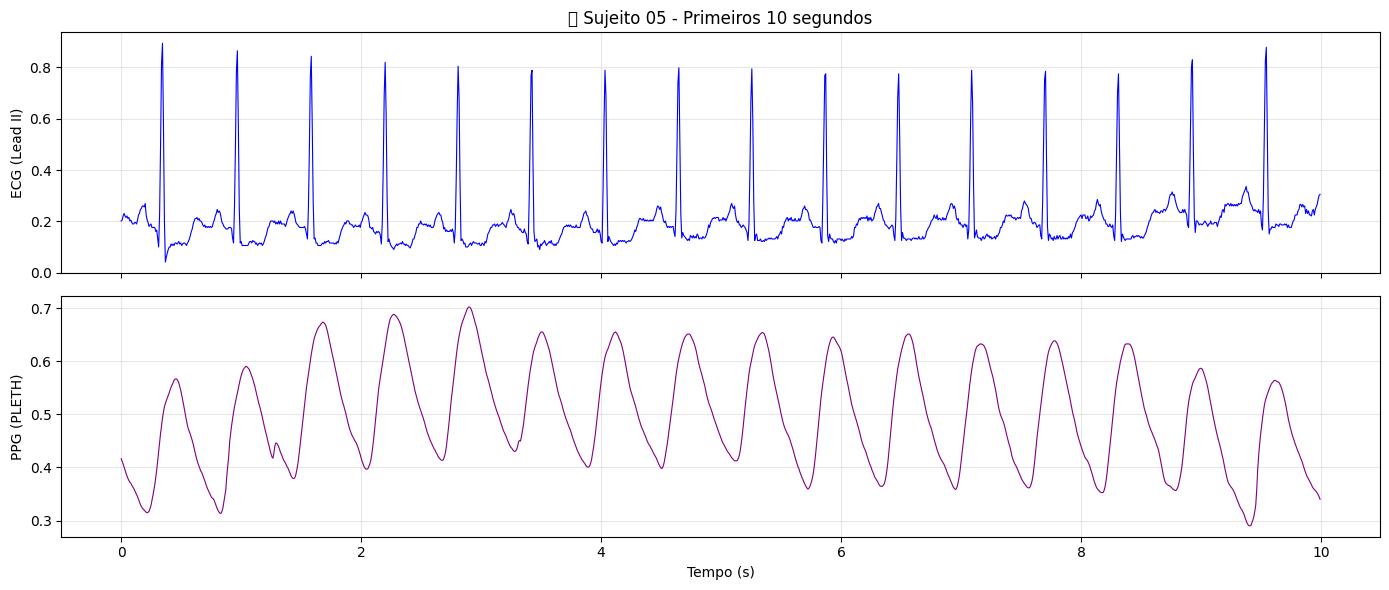

In [4]:
# Plotar primeiros 10 segundos do sujeito 01
subj = subjects[4]
t = np.arange(len(subj['ppg'])) / subj['fs']
end_idx = int(10 * subj['fs'])

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axes[0].plot(t[:end_idx], subj['ecg'][:end_idx], 'b-', linewidth=0.8)
axes[0].set_ylabel('ECG (Lead II)')
axes[0].set_title(f"📊 Sujeito {subj['id']} - Primeiros 10 segundos")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t[:end_idx], subj['ppg'][:end_idx], 'purple', linewidth=0.8)
axes[1].set_ylabel('PPG (PLETH)')
axes[1].set_xlabel('Tempo (s)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Detectando Picos e Criando Labels

In [5]:
def detect_ecg_r_peaks(ecg, fs, min_distance_sec=0.4):
    """
    Detecta picos R no ECG usando derivada + threshold.
    """
    # Filtro passa-banda para QRS (5-25 Hz)
    nyq = fs / 2
    b, a = butter(2, [5/nyq, 25/nyq], btype='band')
    ecg_filt = filtfilt(b, a, ecg)
    
    # Elevar ao quadrado
    ecg_sq = ecg_filt ** 2
    
    # Suavizar
    ecg_smooth = gaussian_filter1d(ecg_sq, sigma=fs * 0.02)
    
    # Detectar picos
    min_dist = int(min_distance_sec * fs)
    threshold = np.percentile(ecg_smooth, 70)
    peaks, _ = find_peaks(ecg_smooth, distance=min_dist, height=threshold)
    
    return peaks


def transfer_peaks_to_ppg(ecg_peaks, ppg, fs, ptt_range=(0.15, 0.35)):
    """
    Transfere picos R do ECG para picos sistólicos do PPG.
    O Pulse Transit Time (PTT) é tipicamente 150-350ms.
    """
    ppg_peaks = []
    ptt_min = int(ptt_range[0] * fs)
    ptt_max = int(ptt_range[1] * fs)
    
    for ecg_peak in ecg_peaks:
        search_start = ecg_peak + ptt_min
        search_end = ecg_peak + ptt_max
        
        if search_end >= len(ppg):
            continue
        
        # Máximo local na janela
        window = ppg[search_start:search_end]
        local_max = np.argmax(window)
        ppg_peaks.append(search_start + local_max)
    
    return np.array(ppg_peaks)


def create_labels_for_subject(subject):
    """
    Cria labels binários para um sujeito.
    """
    ppg = subject['ppg']
    ecg = subject['ecg']
    fs = subject['fs']
    
    # Detectar picos R no ECG
    ecg_peaks = detect_ecg_r_peaks(ecg, fs)
    
    # Transferir para PPG
    ppg_peaks = transfer_peaks_to_ppg(ecg_peaks, ppg, fs)
    
    # Criar array de labels
    labels = np.zeros(len(ppg))
    for peak in ppg_peaks:
        # Marcar região ±3 amostras (±24ms @ 125Hz)
        for offset in range(-3, 4):
            if 0 <= peak + offset < len(labels):
                labels[peak + offset] = 1
    
    return ppg_peaks, labels


# Processar todos os sujeitos
print("🔍 Detectando picos para todos os sujeitos...")
for subj in subjects:
    ppg_peaks, labels = create_labels_for_subject(subj)
    subj['peaks'] = ppg_peaks
    subj['labels'] = labels
    
print(f"✅ Processados {len(subjects)} sujeitos")

# Estatísticas de picos
total_peaks = sum(len(s['peaks']) for s in subjects)
print(f"❤️ Total de batimentos detectados: {total_peaks:,}")

🔍 Detectando picos para todos os sujeitos...
✅ Processados 53 sujeitos
❤️ Total de batimentos detectados: 37,754


### Verificação Visual

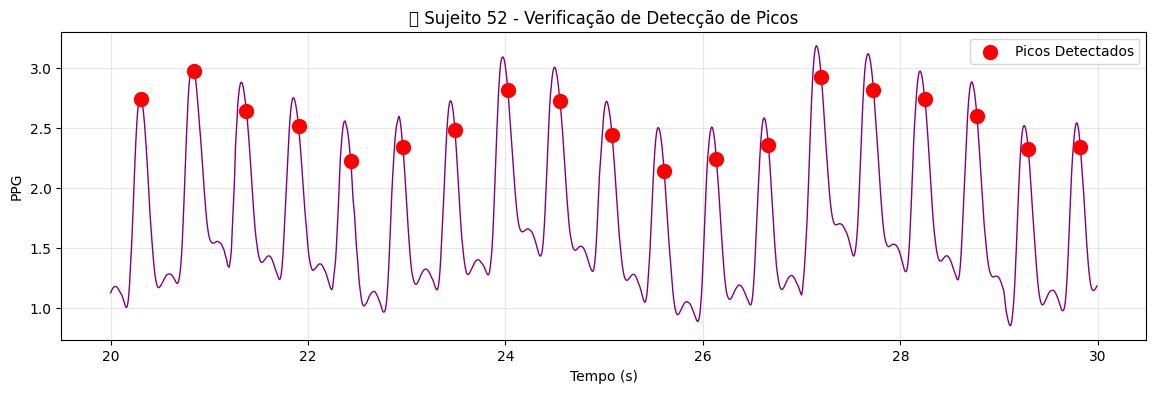

In [6]:
# Plotar sujeito com picos detectados
subj = subjects[51]  # Escolher outro sujeito
start_sec, end_sec = 20, 30
start_idx = int(start_sec * subj['fs'])
end_idx = int(end_sec * subj['fs'])
t = np.arange(len(subj['ppg'])) / subj['fs']

fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(t[start_idx:end_idx], subj['ppg'][start_idx:end_idx], 'purple', linewidth=1)

# Marcar picos detectados
peaks_in_range = subj['peaks'][(subj['peaks'] >= start_idx) & (subj['peaks'] < end_idx)]
ax.scatter(t[peaks_in_range], subj['ppg'][peaks_in_range], 
           c='red', s=100, zorder=5, label='Picos Detectados')

ax.set_xlabel('Tempo (s)')
ax.set_ylabel('PPG')
ax.set_title(f"🎯 Sujeito {subj['id']} - Verificação de Detecção de Picos")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 4. Criando Dataset de Janelas

In [7]:
def create_windows(ppg, labels, window_size, stride):
    """
    Cria janelas de PPG com labels correspondentes.
    """
    X, y = [], []
    
    # Normalizar PPG (Z-score por janela)
    for start in range(0, len(ppg) - window_size, stride):
        window_ppg = ppg[start:start + window_size].copy()
        window_labels = labels[start:start + window_size].copy()
        
        # Z-score normalização
        mean = np.mean(window_ppg)
        std = np.std(window_ppg) + 1e-8
        window_ppg = (window_ppg - mean) / std
        
        # Só incluir janelas com pelo menos 1 pico completo
        if np.sum(window_labels) > 0:
            X.append(window_ppg)
            y.append(window_labels)
    
    return np.array(X), np.array(y)


def prepare_dataset_loso(subjects, test_subject_id, window_size, stride):
    """
    Prepara dataset para validação Leave-One-Subject-Out.
    
    Args:
        subjects: Lista de todos os sujeitos
        test_subject_id: ID do sujeito para teste
        
    Returns:
        X_train, y_train, X_test, y_test
    """
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    for subj in subjects:
        X_subj, y_subj = create_windows(
            subj['ppg'], subj['labels'], window_size, stride
        )
        
        if subj['id'] == test_subject_id:
            X_test.append(X_subj)
            y_test.append(y_subj)
        else:
            X_train.append(X_subj)
            y_train.append(y_subj)
    
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])
    y_test = np.concatenate(y_test, axis=0) if y_test else np.array([])
    
    return X_train, y_train, X_test, y_test


# Criar dataset completo primeiro (para treinamento rápido)
print("📦 Criando janelas de treinamento...")
all_X, all_y = [], []
for subj in subjects:
    X_subj, y_subj = create_windows(subj['ppg'], subj['labels'], WINDOW_SIZE, STRIDE)
    all_X.append(X_subj)
    all_y.append(y_subj)

X_all = np.concatenate(all_X, axis=0)
y_all = np.concatenate(all_y, axis=0)

print(f"✅ Dataset total: {X_all.shape[0]} janelas de {X_all.shape[1]} amostras")

# Split treino/validação (por agora, simples)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.15, random_state=42
)
print(f"🔀 Treino: {len(X_train)} | Validação: {len(X_val)}")

📦 Criando janelas de treinamento...
✅ Dataset total: 12667 janelas de 500 amostras
🔀 Treino: 10766 | Validação: 1901


## 5. Modelo Performer (Transformer com Atenção Linear)

O **Performer** usa FAVOR+ (Fast Attention Via positive Orthogonal Random features)
para computar atenção em O(n) ao invés de O(n²).

Isso é crucial para sinais longos como PPG @ 125Hz.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Dispositivo: {device}")


class PositionalEncoding(nn.Module):
    """Codificação posicional sinusoidal."""
    
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class PerformerAttention(nn.Module):
    """
    Atenção Linear usando FAVOR+ (aproximação do softmax).
    
    Complexidade: O(n) ao invés de O(n²)
    """
    
    def __init__(self, d_model, n_heads=4, n_features=64):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.n_features = n_features
        
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Random features para aproximação do kernel
        self.register_buffer(
            'random_features',
            torch.randn(n_heads, self.head_dim, n_features) / math.sqrt(n_features)
        )
    
    def _feature_map(self, x):
        """Mapa de features positivas para aproximar exp(q·k)."""
        # x: (batch, heads, seq, head_dim)
        # random_features: (heads, head_dim, n_features)
        
        # Projeção random
        x_proj = torch.einsum('bhsd,hdf->bhsf', x, self.random_features)
        
        # Softmax positivo (aproximação)
        return F.softplus(x_proj)
    
    def forward(self, x):
        batch, seq_len, _ = x.shape
        
        # Projeções Q, K, V
        q = self.q_proj(x).view(batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Feature maps
        q_prime = self._feature_map(q)  # (batch, heads, seq, n_features)
        k_prime = self._feature_map(k)
        
        # Atenção linear: O(n*d*m) onde m = n_features
        # kv = k_prime^T @ v
        kv = torch.einsum('bhsf,bhsd->bhfd', k_prime, v)  # (batch, heads, n_features, head_dim)
        
        # Denominador para normalização
        k_sum = k_prime.sum(dim=2, keepdim=True)  # (batch, heads, 1, n_features)
        
        # Numerador
        qkv = torch.einsum('bhsf,bhfd->bhsd', q_prime, kv)  # (batch, heads, seq, head_dim)
        
        # Denominador por posição
        denom = torch.einsum('bhsf,bhof->bhs', q_prime, k_sum) + 1e-8
        
        # Output normalizado
        out = qkv / denom.unsqueeze(-1)
        
        # Reshape e projeção final
        out = out.transpose(1, 2).contiguous().view(batch, seq_len, self.d_model)
        return self.out_proj(out)


class PerformerBlock(nn.Module):
    """Bloco Transformer com Performer Attention."""
    
    def __init__(self, d_model, n_heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.attention = PerformerAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Self-attention com residual
        attn_out = self.attention(self.norm1(x))
        x = x + self.dropout(attn_out)
        
        # Feed-forward com residual
        ff_out = self.ff(self.norm2(x))
        x = x + ff_out
        
        return x


class PPGPeakPerformer(nn.Module):
    """
    Modelo Performer para detecção de picos em PPG.
    
    Arquitetura:
    - Embedding 1D (Conv)
    - Positional Encoding
    - N x Performer Blocks
    - Decoder (Conv 1D)
    """
    
    def __init__(self, window_size=500, d_model=64, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        
        # Embedding: 1D signal -> d_model features
        self.embedding = nn.Sequential(
            nn.Conv1d(1, d_model // 2, kernel_size=7, padding=3),
            nn.BatchNorm1d(d_model // 2),
            nn.GELU(),
            nn.Conv1d(d_model // 2, d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.GELU()
        )
        
        self.pos_encoding = PositionalEncoding(d_model, max_len=window_size)
        
        # Performer blocks
        self.transformer = nn.ModuleList([
            PerformerBlock(d_model, n_heads, ff_dim=d_model * 4, dropout=dropout)
            for _ in range(n_layers)
        ])
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(d_model, d_model // 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model // 2),
            nn.GELU(),
            nn.Conv1d(d_model // 2, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x: (batch, window_size)
        batch, seq_len = x.shape
        
        # Embedding
        x = x.unsqueeze(1)  # (batch, 1, seq_len)
        x = self.embedding(x)  # (batch, d_model, seq_len)
        x = x.transpose(1, 2)  # (batch, seq_len, d_model)
        
        # Positional encoding
        x = self.pos_encoding(x)
        
        # Transformer blocks
        for block in self.transformer:
            x = block(x)
        
        # Decoder
        x = x.transpose(1, 2)  # (batch, d_model, seq_len)
        x = self.decoder(x)  # (batch, 1, seq_len)
        
        return x.squeeze(1)  # (batch, seq_len)


# Criar modelo
model = PPGPeakPerformer(
    window_size=WINDOW_SIZE,
    d_model=64,
    n_heads=4,
    n_layers=4,
    dropout=0.1
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"🏗️ Modelo Performer criado: {n_params:,} parâmetros")

🖥️ Dispositivo: cpu
🏗️ Modelo Performer criado: 221,121 parâmetros


## 6. Treinamento

In [9]:
def train_performer(model, X_train, y_train, X_val, y_val, 
                   epochs=50, batch_size=64, lr=1e-3):
    """
    Treina o modelo Performer.
    """
    # Tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)
    
    # DataLoader
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    # Loss e optimizer
    # Usar Focal Loss para lidar com desbalanceamento (poucos 1s, muitos 0s)
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_losses.append(loss.item())
        
        scheduler.step()
        
        # Validação
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_t)
            val_loss = criterion(y_val_pred, y_val_t).item()
            
            # F1 Score aproximado
            y_pred_bin = (y_val_pred > 0.5).float()
            tp = (y_pred_bin * y_val_t).sum()
            fp = (y_pred_bin * (1 - y_val_t)).sum()
            fn = ((1 - y_pred_bin) * y_val_t).sum()
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
        
        train_loss = np.mean(train_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(f1.item())
        
        # Log
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | F1: {f1:.4f}")
        
        # Early save
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_performer.pth')
    
    # Carregar melhor modelo
    model.load_state_dict(torch.load('best_performer.pth'))
    
    return history


# Treinar
print("🚀 Iniciando treinamento do Performer...")
# history = train_performer(model, X_train, y_train, X_val, y_val, epochs=50)


# Depois de 50 epocas ter chego em F1 0.7174 e a curva de aprendizado parecer ainda ascendente, resolvi continuar com mais 30 epocas

# Carregar checkpoint do treino anterior
model.load_state_dict(torch.load('best_performer.pth'))
print("✅ Checkpoint carregado!")
# Continuar treinando mais 30 épocas
history = train_performer(model, X_train, y_train, X_val, y_val, epochs=30)

🚀 Iniciando treinamento do Performer...
✅ Checkpoint carregado!
Epoch  10/30 | Train: 0.0977 | Val: 0.1040 | F1: 0.7159
Epoch  20/30 | Train: 0.0865 | Val: 0.0993 | F1: 0.7340
Epoch  30/30 | Train: 0.0809 | Val: 0.0936 | F1: 0.7522


### Curvas de Aprendizado

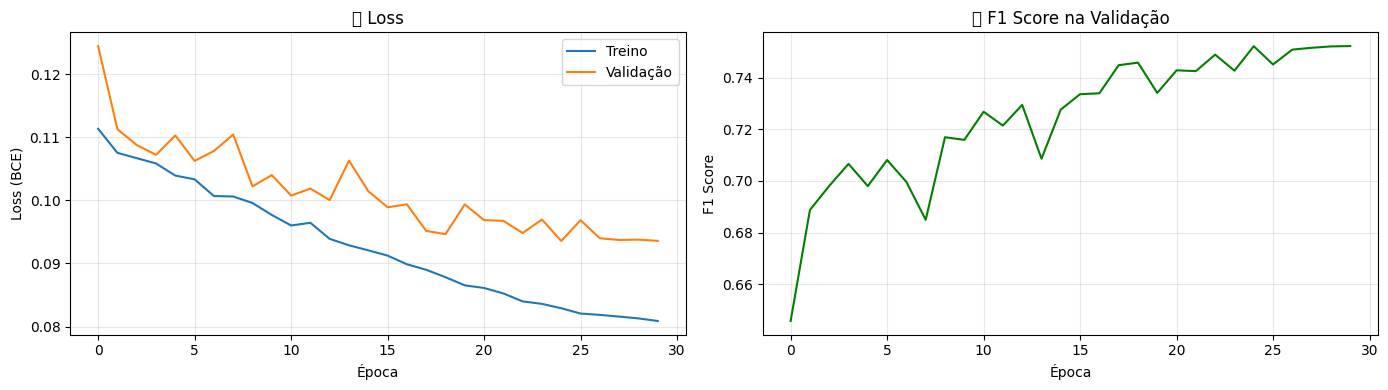

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history['train_loss'], label='Treino')
axes[0].plot(history['val_loss'], label='Validação')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (BCE)')
axes[0].set_title('📉 Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


axes[1].plot(history['val_f1'], color='green')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('🎯 F1 Score na Validação')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Avaliação Visual

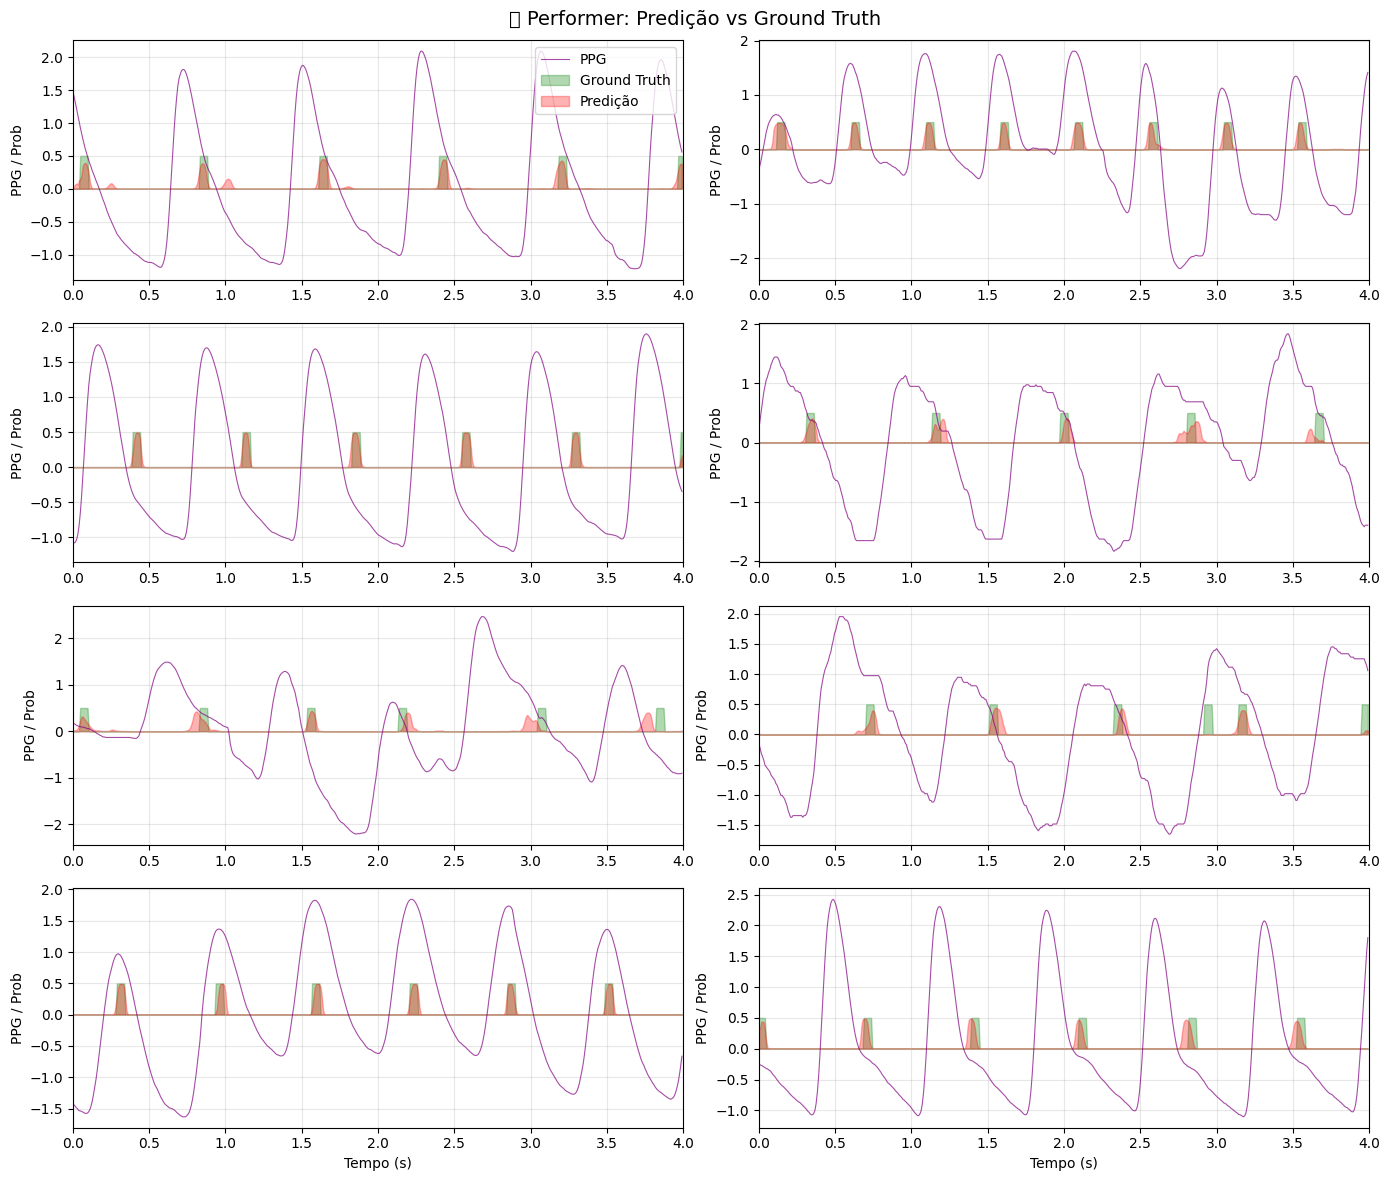

In [11]:
# Predição em algumas janelas de validação
model.eval()
with torch.no_grad():
    X_sample = torch.FloatTensor(X_val[:8]).to(device)
    y_pred = model(X_sample).cpu().numpy()

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

t_window = np.arange(WINDOW_SIZE) / FS

for i, ax in enumerate(axes):
    ax.plot(t_window, X_val[i], 'purple', alpha=0.7, linewidth=0.8, label='PPG')
    ax.fill_between(t_window, y_val[i] * 0.5, alpha=0.3, color='green', label='Ground Truth')
    ax.fill_between(t_window, y_pred[i] * 0.5, alpha=0.3, color='red', label='Predição')
    ax.set_xlim([0, WINDOW_SEC])
    ax.set_ylabel('PPG / Prob')
    if i >= 6:
        ax.set_xlabel('Tempo (s)')
    if i == 0:
        ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

fig.suptitle('🎯 Performer: Predição vs Ground Truth', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Inferência nos Seus Dados (ESP32)

Carregue um arquivo do seu ESP32, decime para 125Hz, e rode o modelo.

In [ ]:
def load_esp32_and_predict(model, filepath, original_fs=757, target_fs=125):
    """
    Carrega dados do ESP32, decima, e prediz picos.
    """
    # Carregar dados
    try:
        df = pd.read_csv(filepath)
        if 'ir_waveform' in df.columns:
            ppg = df['ir_waveform'].values
        elif 'IR' in df.columns:
            ppg = df['IR'].values
        else:
            ppg = df.iloc[:, 0].values
        print(f"✅ Carregado: {len(ppg)} amostras @ {original_fs}Hz")
    except Exception as e:
        print(f"⚠️ Erro ao carregar: {e}")
        print("   Usando dado sintético do BIDMC para demonstração...")
        ppg = subjects[10]['ppg'][:original_fs * 30]  # 30 segundos
        original_fs = 125  # Já está em 125Hz
    
    # Decimar se necessário
    if original_fs != target_fs:
        n_samples = int(len(ppg) * target_fs / original_fs)
        ppg_resampled = resample(ppg, n_samples)
        print(f"📉 Decimado para {target_fs}Hz: {len(ppg_resampled)} amostras")
    else:
        ppg_resampled = ppg
    
    # Predição com janelas sobrepostas
    window_size = WINDOW_SIZE
    stride = window_size // 4
    
    predictions = np.zeros(len(ppg_resampled))
    counts = np.zeros(len(ppg_resampled))
    
    model.eval()
    with torch.no_grad():
        for start in range(0, len(ppg_resampled) - window_size, stride):
            window = ppg_resampled[start:start + window_size]
            
            # Normalizar
            window_norm = (window - np.mean(window)) / (np.std(window) + 1e-8)
            
            # Predizer
            window_t = torch.FloatTensor(window_norm).unsqueeze(0).to(device)
            pred = model(window_t).cpu().numpy().squeeze()
            
            predictions[start:start + window_size] += pred
            counts[start:start + window_size] += 1
    
    # Média das predições sobrepostas
    predictions = predictions / np.maximum(counts, 1)
    
    # Encontrar picos
    peaks, _ = find_peaks(predictions, height=0.5, distance=int(0.4 * target_fs))
    
    return ppg_resampled, predictions, peaks


# Testar com um arquivo ESP32 ou usar dado BIDMC
esp32_path = os.path.join(ESP32_DIR, 'sample.csv')  # Ajuste para seu arquivo

ppg_esp32, probs, detected_peaks = load_esp32_and_predict(model, esp32_path)

# Calcular HR
if len(detected_peaks) > 1:
    rr = np.diff(detected_peaks) / FS * 1000  # ms
    hr = 60000 / np.mean(rr)
    sdnn = np.std(rr)
    print(f"\n❤️ HR: {hr:.1f} BPM | SDNN: {sdnn:.1f} ms | {len(detected_peaks)} picos")

### Visualização da Inferência

In [ ]:
t = np.arange(len(ppg_esp32)) / FS

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# PPG com picos
axes[0].plot(t, ppg_esp32, 'purple', linewidth=0.8)
axes[0].scatter(t[detected_peaks], ppg_esp32[detected_peaks], 
                c='red', s=80, zorder=5, label='Picos Detectados')
axes[0].set_ylabel('PPG')
axes[0].set_title('🎯 Inferência Performer no Sinal ESP32')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Probabilidades
axes[1].plot(t, probs, 'orange', linewidth=0.8)
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')
axes[1].set_ylabel('P(pico)')
axes[1].set_xlabel('Tempo (s)')
axes[1].set_ylim(-0.05, 1.05)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Salvar Modelo Final

In [ ]:
save_path = '/home/douglas/Documentos/Projects/PPG/pulse-analytics/analytics/performer_peak_detector.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'window_size': WINDOW_SIZE,
        'target_fs': FS,
        'd_model': 64,
        'n_heads': 4,
        'n_layers': 4
    }
}, save_path)

print(f"💾 Modelo salvo em: {save_path}")

## 🎓 Resumo

| Etapa | O que fizemos |
|-------|---------------|
| **1. Dados** | Carregamos 53 sujeitos BIDMC (PPG + ECG @ 125Hz) |
| **2. Labels** | Detectamos pico R no ECG → transferimos para PPG (PTT ~200ms) |
| **3. Janelas** | Criamos janelas de 4s com labels binários |
| **4. Modelo** | Performer (Transformer com atenção O(n)) |
| **5. Treino** | BCE Loss + AdamW + Cosine Annealing |
| **6. Inferência** | Predição com overlap → find_peaks → RR intervals |

### Próximos Passos
- [ ] Validação LOSO completa (53 folds)
- [ ] Fine-tuning com seus dados ESP32
- [ ] Exportar para ONNX / TensorFlow Lite
- [ ] Deploy no ESP32 (Micro)